In [23]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

In [2]:
key = random.PRNGKey(0)
x = random.normal(key, (10, ))
print(x)

[-0.3721109   0.26423115 -0.18252768 -0.7368197  -0.44030377 -0.1521442
 -0.67135346 -0.5908641   0.73168886  0.5673026 ]


In [5]:
size = 150
x = random.normal(key, (size, size), dtype = jnp.float32)
%timeit jnp.dot(x, x.T).block_until_ready()  # runs on the GPU

208 µs ± 6.92 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [6]:
import numpy as np
x = np.random.normal(size = (size, size)).astype(np.float32)
%timeit jnp.dot(x, x.T).block_until_ready()

137 µs ± 2.12 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


#### Using `jit()`

In [7]:
def selu(x, alpha = 1.67, lmbda=1.05):
    return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

x = random.normal(key, (1000000, ))
%timeit selu(x).block_until_ready()

1.98 ms ± 204 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
selu_jit = jit(selu)
%timeit selu_jit(x).block_until_ready()

403 µs ± 7.92 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [12]:
def sum_logistic(x):
    return jnp.sum(1.0 / (1.0 + jnp.exp(-x)))

x_small = jnp.arange(3.)

derivative_fn = grad(sum_logistic)

print(derivative_fn(x_small))

[0.25       0.19661197 0.10499357]


In [9]:
jnp.arange(3.)

DeviceArray([0., 1., 2.], dtype=float32)

#### Using `vmap()`

In [3]:
mat = random.normal(key, (150, 100))
batched_x = random.normal(key, (10, 100))

def apply_matrix(v):
    return jnp.dot(mat, v)

In [4]:
def naively_batched_apply_matrix(v_batched):
    return jnp.stack([apply_matrix(v) for v in v_batched])

In [6]:
%timeit naively_batched_apply_matrix(batched_x).block_until_ready()

1.4 ms ± 3.22 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### A simple Training loop in JAX

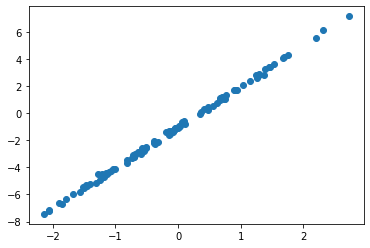

In [18]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.random.normal(size = (100, ))
noise = np.random.normal(scale = 0.1, size = (100, ))
ys = xs * 3 - 1 + noise

plt.scatter(xs, ys)

In [19]:
def model(theta, x):
    """Computes wx + b on a batch of input x."""
    w, b = theta
    return w * x + b

In [20]:
def loss_fn(theta, x, y):
    prediction = model(theta, x)
    return jnp.mean((prediction - y) ** 2)

In [21]:
def update(theta, x, y, lr=0.1):
    return theta - lr * jax.grad(loss_fn)(theta, x, y)

w: 3.00, b: -1.02


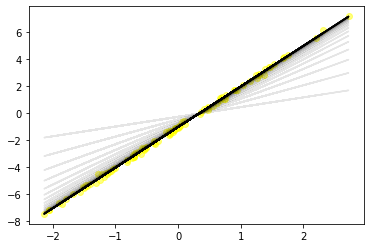

In [36]:
theta = jnp.array([0., 0.])
for _ in range(50):
  theta = update(theta, xs, ys)
  plt.plot(xs, model(theta, xs), alpha = 0.10, color = 'black')

plt.scatter(xs, ys, color = 'yellow', alpha = 0.5)

w, b = theta
print(f"w: {w:<.2f}, b: {b:<.2f}")

#### Higher Order Derivatives

##### Scalar case

In [42]:
f = lambda x: x**3 + 2*x**2 - 3*x + 1
dfdx = jax.grad(f)
d2fdx = jax.grad(dfdx)

In [44]:
print(dfdx(1.0))
print(d2fdx(1.0))

4.0
10.0


##### Multivariate case

In [49]:
def hessian(f):
    return jax.jacfwd(jax.grad(f))

def hessian_naive(f):
    return jax.jacrev(jax.grad(f))

In [46]:
def f(x):
    return jnp.dot(x, x)

In [55]:
%timeit hessian(f)(jnp.array([1., 2., 3.]))

2.97 ms ± 30.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [56]:
%timeit hessian_naive(f)(jnp.array([1., 2., 3.]))

3.77 ms ± 56.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Random Numbers

In [57]:
from jax import random

key = random.PRNGKey(42)
print(key)

[ 0 42]


In [59]:
print(random.normal(key))
print(random.normal(key))

-0.18471177
-0.18471177


Instead of reusing keys, we want to generate new keys all the time.

In [60]:
print("old key", key)
new_key, subkey = random.split(key)
del key  # The old key is discarded -- we must never use it again.
normal_sample = random.normal(subkey)
print(r"    \---SPLIT --> new key   ", new_key)
print(r"             \--> new subkey", subkey, "--> normal", normal_sample)
del subkey  # The subkey is also discarded after use.

# Note: you don't actually need to `del` keys -- that's just for emphasis.
# Not reusing the same values is enough.

key = new_key  # If we wanted to do this again, we would use new_key as the key.

old key [ 0 42]
    \---SPLIT --> new key    [2465931498 3679230171]
             \--> new subkey [255383827 267815257] --> normal 1.3694694


One more example illustrating key behavior.

In [61]:
key = random.PRNGKey(42)
subkeys = random.split(key, 3)
sequence = np.stack([random.normal(subkey) for subkey in subkeys])
print("individually:", sequence)

key = random.PRNGKey(42)
print("all at once: ", random.normal(key, shape=(3,)))

individually: [-0.04838832  0.10796154 -1.2226542 ]
all at once:  [ 0.18693547 -1.2806505  -1.5593132 ]


#### pytree s

In [62]:
import jax
import jax.numpy as jnp

example_trees = [
                    [1, 'a', object()],
                    (1, (2, 3), ()),
                    [1, {'k1': 2, 'k2': (3, 4)}, 5],
                    {'a': 2, 'b': (2, 3)},
                    jnp.array([1, 2, 3]),
                 ]

# Let's see how many leaves they have:
for pytree in example_trees:
  leaves = jax.tree_leaves(pytree)
  print(f"{repr(pytree):<45} has {len(leaves)} leaves: {leaves}")

[1, 'a', <object object at 0x7f508dec4850>]   has 3 leaves: [1, 'a', <object object at 0x7f508dec4850>]
(1, (2, 3), ())                               has 3 leaves: [1, 2, 3]
[1, {'k1': 2, 'k2': (3, 4)}, 5]               has 5 leaves: [1, 2, 3, 4, 5]
{'a': 2, 'b': (2, 3)}                         has 3 leaves: [2, 2, 3]
DeviceArray([1, 2, 3], dtype=int32)           has 1 leaves: [DeviceArray([1, 2, 3], dtype=int32)]


#### pytrees for MLP training

In [81]:
import numpy as np

def init_mlp_params(layer_widths):
    params = []
    for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
        params.append(
            dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
                 biases=np.ones(shape=(n_out,))
                )
        )
    return params

params = init_mlp_params([1, 128, 128, 1])

In [82]:
jax.tree_map(lambda x: x.shape, params)

[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (1,), 'weights': (128, 1)}]

In [83]:
def forward(params, x):
    *hidden, last = params
    for layer in hidden:
        x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
    return x @ last['weights'] + last['biases']

def loss_fn(params, x, y):
    return jnp.mean((forward(params, x) - y) ** 2)

LEARNING_RATE = 0.0001

@jax.jit
def update(params, x, y):
    grads = jax.grad(loss_fn)(params, x, y)
    # Note that `grads` is a pytree with the same structure as `params`.
    # `jax.grad` is one of the many JAX functions that has
    # built-in support for pytrees.

    # This is handy, because we can apply the SGD update using tree utils:
    return jax.tree_map(lambda p, 
                        g: p - LEARNING_RATE * g, 
                        params, 
                        grads)

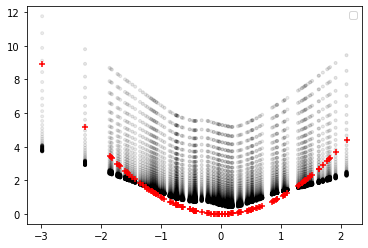

In [101]:
import matplotlib.pyplot as plt

params = init_mlp_params([1, 128, 128, 1])

xs = np.random.normal(size=(128, 1))
ys = xs ** 2

for _ in range(100):
  params = update(params, xs, ys)
  plt.scatter(xs, forward(params, xs), alpha = (10 + i) / 110, marker = '.',
             color = 'black')

plt.scatter(xs, ys, marker = '+', color = 'red')
#plt.scatter(xs, forward(params, xs), label='Model prediction')
plt.legend();

#### transposing pytrees

In [109]:
def tree_transpose(list_of_trees):
  """Convert a list of trees of identical structure into a single tree of lists."""
  return jax.tree_map(lambda *xs: list(xs), *list_of_trees)

# Convert a dataset from row-major to column-major:
episode_steps = [dict(t=1, obs=3), dict(t=2, obs=4)]
tree_transpose(episode_steps)

{'obs': [3, 4], 't': [1, 2]}

In [106]:
*lot = episode_steps

SyntaxError: starred assignment target must be in a list or tuple (<ipython-input-106-b302c791ec12>, line 4)